# Imports 

------------------------------
Import modules used to complete this note book. 

*sci-kit learn version 1 is also installed here, as the raspberry pi runs on scikit learn version 1 but google collab uses version 0.22*

--------------------------

In [ ]:
import numpy as np
import pandas as pd
from six import StringIO
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, classification_report,f1_score,recall_score,precision_score

from sklearn.metrics import confusion_matrix
import pickle 
import sklearn

!pip install delayed
from sklearn.inspection import permutation_importance

!pip uninstall scikit-learn -y
!pip install -U scikit-learn

sklearn.__version__

     |████████████████████████████████| 72 kB 653 kB/s 
     |████████████████████████████████| 85 kB 4.6 MB/s 
Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 23.2 MB 71.9 MB/s 


'0.22.2.post1'

In [ ]:
sklearn.__version__

'0.22.2.post1'

# Alternate import data statement 

no preprocessing required here

In [ ]:
df=pd.read_csv("argumentedbedroom")

df.columns = ['time','status','day','hour','min','second']


# Preprocessing


---------------------------------

In this section, the data i initally imported was changed in a format which could be used in machine learning, such as changing the words of the weekdays to numbers and changing the status of the appliance from words to numbers. however later the format of the data i produced changed so this was not needed to apply, but i kept this here as proof of work.

--------------------------------

In [ ]:
from sklearn import preprocessing

def endcode_data(data):
  string_to_int= preprocessing.LabelEncoder()
  transformed_df = df[data].apply(string_to_int.fit_transform)
  return df

def preprocessing_self(data):
    encoded_data = endcode_data(data)
    return encoded_data


  

In [ ]:
string_to_int= preprocessing.LabelEncoder()                    

df['day']= string_to_int.fit_transform(df['day'])

df['status']= string_to_int.fit_transform(df['status'])

# Plot Status Over Time

------------------------------------

A simple plot of the data which i used to ensure that the data looks correct. it shows when an appliance is on or off in a 24 hour time frame. this is not a 100 percent accurate as times overlap as week days change. 

however it is effective at viewing the data in a simple way. 

------------------------------------

Text(0, 0.5, 'status')

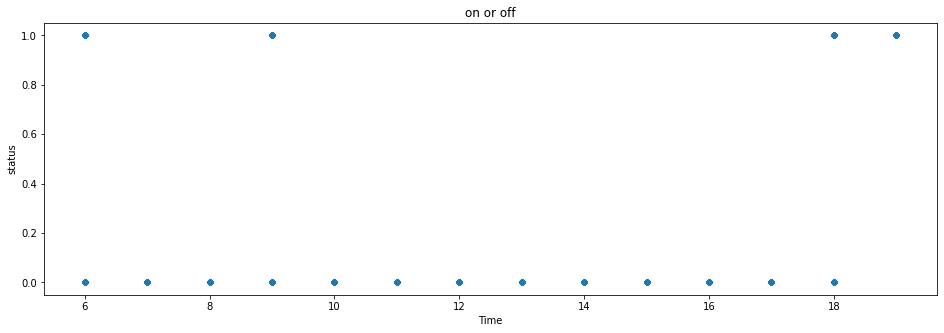

In [ ]:
ax = df.plot(figsize=(16,5),kind = 'scatter',x = 'hour', y = 'status',  title='on or off')
ax.set_xlabel("Time")
ax.set_ylabel("status")

# Test Train Split 

---------------------------------------

Split the data set into a traning and testing split, as well as defining the feature colums. 
the feature colums in this case is Days, hours, minuites and seconds.

----------------------------------------

In [ ]:
feature_cols = ['day','hour','min','second']
X = df[feature_cols]                              
y = df.status    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Build pipeline 


----------------------------------

Build the pipeline of the four different classifiers to apply the training too. 

----------------------------------

In [ ]:
pipeline_svc = Pipeline(
    [
      (('svc', SVC(kernel='linear'))
    ),]
)

pipeline_CLF = Pipeline(
    [('CLF', MLPClassifier(random_state=42, max_iter=3000)
     ),]
)

pipeline_LR = Pipeline(
    [ ('LR', LogisticRegression(random_state=42)
     ),]
)

pipeline_GNB = Pipeline(
    [
     ('GNB',GaussianNB()
     ),]
)

pipeline_svc.fit(X_train,y_train)
pipeline_CLF.fit(X_train,y_train)
pipeline_LR.fit(X_train,y_train)
pipeline_GNB.fit(X_train,y_train)

estimators_list = [
    
    pipeline_svc
    ,pipeline_CLF
    ,pipeline_LR
    ,pipeline_GNB

]


# Learning phase 



----------------------------
Apply the gridsearch function to the different estimators that we use for this project. 

the best estimators were then saved and used in testing later on. 

------------------------------

In [ ]:
parameters_svc =   [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

paramaters_clf = { 
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],   
}

parameters_LR = {
     "C": [0.001, 0.01, 0.1, 1, 10, 100]
}

parameters_GNB = {
  'var_smoothing': np.logspace(0,-9, num=100)
}



grid_pipeline_svc =  GridSearchCV(estimator = pipeline_svc['svc'], param_grid = parameters_svc, cv = 5).fit(X_train,y_train)

grid_pipeline_clf =  GridSearchCV(estimator = pipeline_CLF['CLF'], param_grid = paramaters_clf, cv = 5).fit(X_train,y_train)

grid_pipeline_LR =  GridSearchCV(estimator = pipeline_LR['LR'], param_grid = parameters_LR, cv = 5).fit(X_train,y_train)

grid_pipeline_GNB =  GridSearchCV(estimator = pipeline_GNB['GNB'], param_grid = parameters_GNB, cv = 5).fit(X_train,y_train)


paramaters_list = [
    parameters_svc ,paramaters_clf,parameters_LR,parameters_GNB
]

best_SVC_estimator = grid_pipeline_svc.best_estimator_
best_CLF_estimator = grid_pipeline_clf.best_estimator_
best_LR_estimator = grid_pipeline_LR.best_estimator_
best_GNB_estimator = grid_pipeline_GNB.best_estimator_


# Cross validation scoring 

-----------------------------

In this section,the cross validation scores of the different models were calculated.  

-----------------------------

In [ ]:
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

models = {
    best_SVC_estimator, best_CLF_estimator,best_LR_estimator,best_GNB_estimator
}

scores = []
for model in models: 
  scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=5, return_train_score=False)
  test_fit_time = list(scores['fit_time'])
  test_score_time = list(scores['score_time'])
  test_accuracy = list(scores['test_accuracy'])
  test_recall = list(scores['test_recall_macro'])
  test_precision = list(scores['test_precision_macro'])
  test_f1 = list(scores['test_f1_macro'])

  print ('------------------------------------------------------------')
  print ('N-FOLD CROSS VALIDATION RESULT OF', model.__class__.__name__)
  print ('------------------------------------------------------------')
  print ('n-fold fit_time: %0.9f ' % (np.sum(test_fit_time)))
  print ('n-fold score_time: %0.9f ' % (np.sum(test_score_time)))
  print ('------------------------------------------------------------')
  print ('n-fold average accuracy: %0.9f (+/- %0.9f)' % (np.mean(test_accuracy)*100, np.std(test_accuracy)))
  print ('n-fold average recall: %0.9f (+/- %0.9f)' % (np.mean(test_recall)*100, np.std(test_recall)))
  print ('n-fold average precision: %0.9f (+/- %0.9f)' % (np.mean(test_precision)*100, np.std(test_precision)))
  print ('n-fold average f1: %0.9f (+/- %0.9f)' % (np.mean(test_f1)*100, np.std(test_f1)))



------------------------------------------------------------
N-FOLD CROSS VALIDATION RESULT OF GaussianNB
------------------------------------------------------------
n-fold fit_time: 0.015164614 
n-fold score_time: 0.021571159 
------------------------------------------------------------
n-fold average accuracy: 63.202846975 (+/- 0.012206458)
n-fold average recall: 60.964630225 (+/- 0.012279217)
n-fold average precision: 63.541308606 (+/- 0.016078005)
n-fold average f1: 60.173271055 (+/- 0.013612359)
------------------------------------------------------------
N-FOLD CROSS VALIDATION RESULT OF MLPClassifier
------------------------------------------------------------
n-fold fit_time: 44.332043409 
n-fold score_time: 0.038419485 
------------------------------------------------------------
n-fold average accuracy: 98.879003559 (+/- 0.003309800)
n-fold average recall: 98.964079374 (+/- 0.003173099)
n-fold average precision: 98.790122964 (+/- 0.003447760)
n-fold average f1: 98.868306639 

# Classification reports of models based on test data 

----------------

In this section print the classification reports based on the test data. 

This section produced some interesting results. For a reason that i am unsure of, MLP performs extremely well, too well. 

This problem is likely based on the fact that not all of the data used for the training is random, as i had to generate data for the project myself, as i could not find a real world data set. 

-----------------

In [ ]:
i = 0 
predictions = []
metric_scores = []
for model in models:
  predictions.append(model.predict(X_test))
  print('Classification Report of ', model.__class__.__name__ )
  print(classification_report(y_test, predictions[i])) 
  i += 1

Classification Report of  GaussianNB
              precision    recall  f1-score   support

           0       0.66      0.82      0.73       828
           1       0.60      0.38      0.47       578

    accuracy                           0.64      1406
   macro avg       0.63      0.60      0.60      1406
weighted avg       0.63      0.64      0.62      1406

Classification Report of  MLPClassifier
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       828
           1       0.94      1.00      0.96       578

    accuracy                           0.97      1406
   macro avg       0.97      0.97      0.97      1406
weighted avg       0.97      0.97      0.97      1406

Classification Report of  LogisticRegression
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       828
           1       0.70      0.70      0.70       578

    accuracy                           0.76      1406
   mac

# Learning curve, scalability curve and fit time performance curve of best model.  

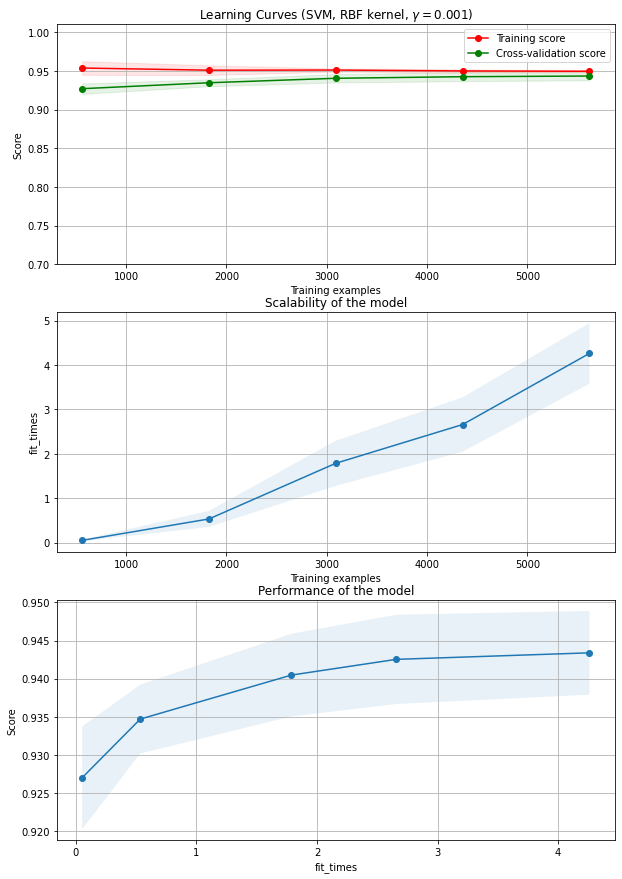

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 1, figsize=(10, 15))



title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(kernel='linear')


plot_learning_curve(best_SVC_estimator, title, X, y, axes=axes[:], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=None)

plt.show()


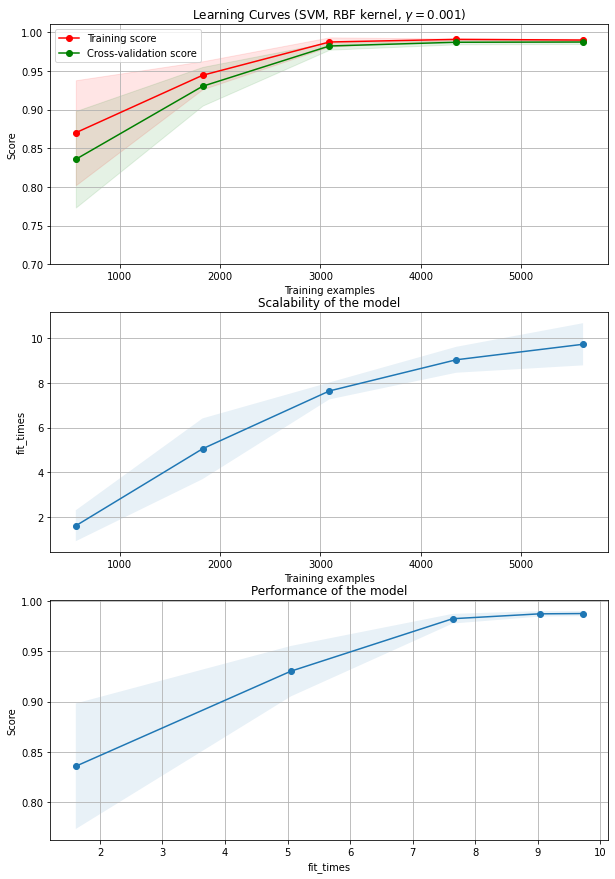

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 1, figsize=(10, 15))



title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(kernel='linear')


plot_learning_curve(best_CLF_estimator, title, X, y, axes=axes[:], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=None)
plt.show()

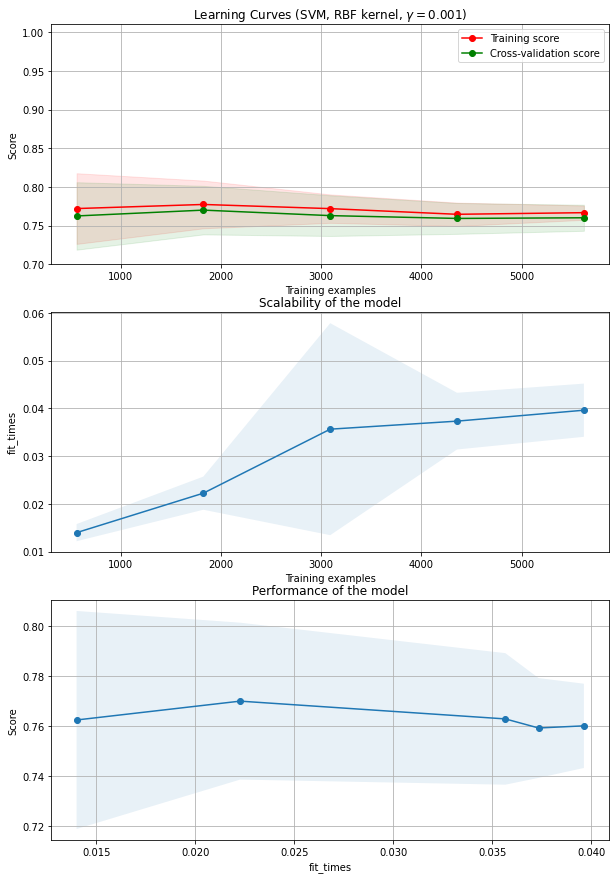

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 1, figsize=(10, 15))



title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(kernel='linear')
plot_learning_curve(best_LR_estimator, title, X, y, axes=axes[:], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=None)
plt.show()

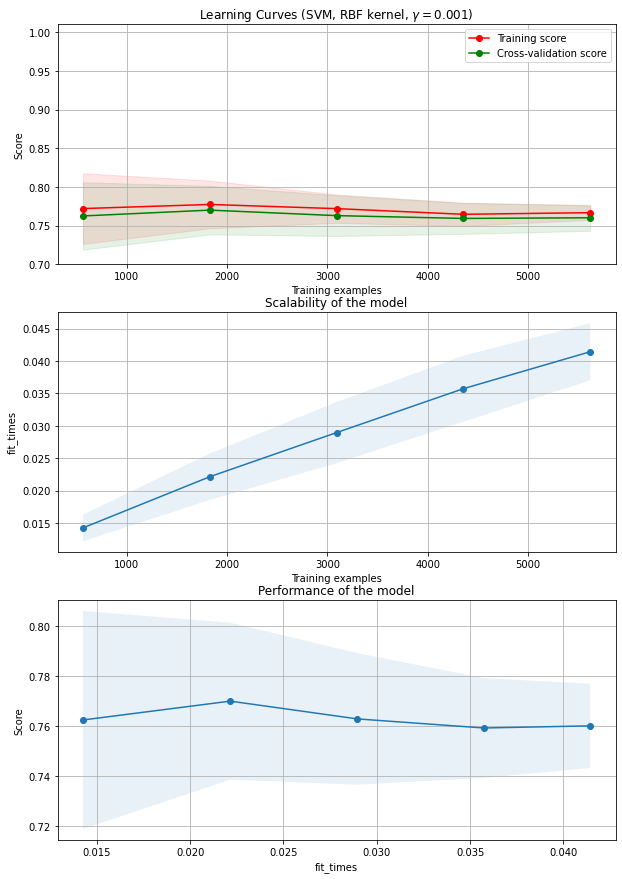

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 1, figsize=(10, 15))



title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(kernel='linear')
plot_learning_curve(best_LR_estimator, title, X, y, axes=axes[:], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=None)
plt.show()

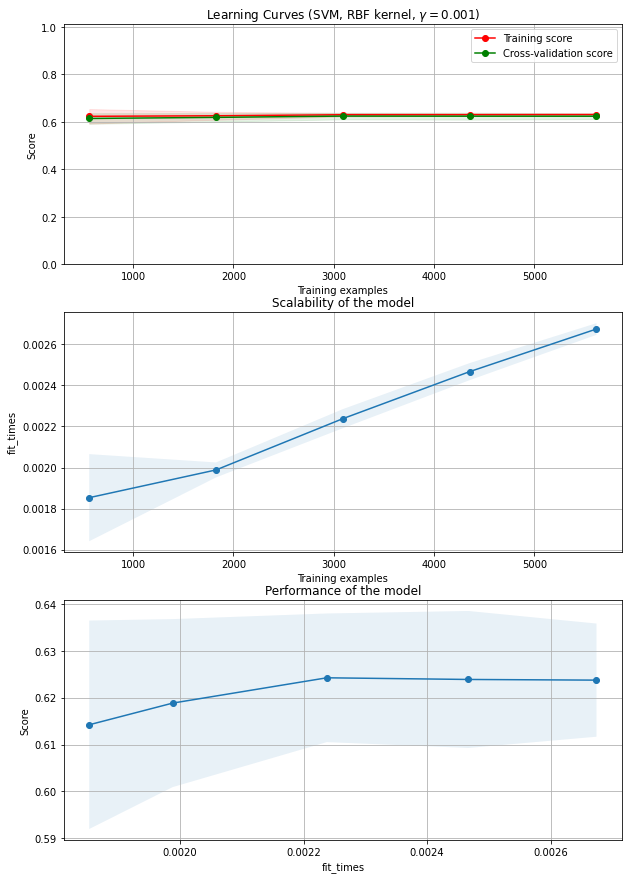

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 1, figsize=(10, 15))



title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(kernel='linear')
plot_learning_curve(best_GNB_estimator, title, X, y, axes=axes[:], ylim=(0.0, 1.01),
                    cv=cv, n_jobs=None)
plt.show()

# Feature Importance


---------------------

The best model i chose for the project was the SVC estimator, as MLP performs *too well* 

SVC does not have a naitive feature importance function when its kernel is RBF based, so i had to use permutation_importance. 

----------------

In [ ]:
perm_importance = permutation_importance(best_SVC_estimator, X_test, y_test)
feature_names = ['day', 'hour', 'min', 'second']
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")



#Save Model

------------------------

This saves the best estimator to my google drive, which can then use on the Raspberry Pi

-------------------------

In [ ]:
with open('/content/drive/MyDrive/first_model.pkl', 'wb') as f: 
 pickle.dump(best_SVC_estimator, f)